# АНСАМБЛИ МОДЕЛЕЙ

In [3]:
!pip install jupyterthemes

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from jupyterthemes import jtplot
from sklearn.metrics import auc, roc_curve, roc_auc_score
%matplotlib inline
jtplot.style()

## Часть 0. Деревья решений

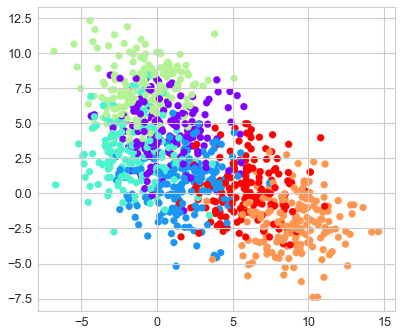

In [6]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=1000, centers=6,
                  random_state=0, cluster_std=2.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow')
plt.show()

In [23]:
# [ 5.91075553,  1.60333344],
# X[:, 1]

In [31]:
def visualize_tree(estimator, X, y, ax=None, fit=True):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap='viridis',
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    if fit:
        estimator.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    n_classes = len(np.unique(y))
    Z = Z.reshape(xx.shape)
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap='viridis',
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

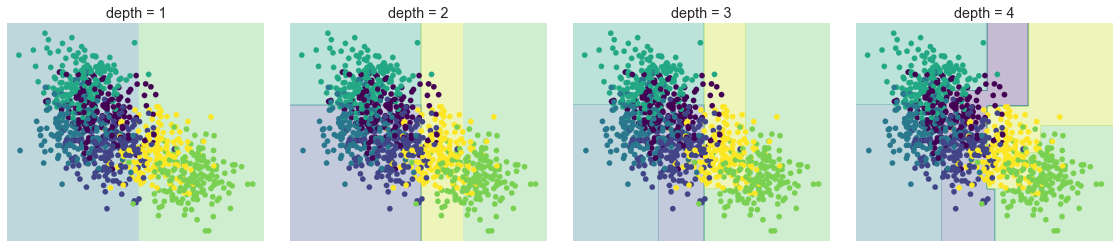

In [32]:
from sklearn.tree import DecisionTreeClassifier
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
fig.subplots_adjust(left=0.02, right=0.98, wspace=0.1)
for axi, depth in zip(ax, range(1, 5)):
    model = DecisionTreeClassifier(max_depth=depth)
    visualize_tree(model, X, y, ax=axi, fit=True)
    axi.set_title('depth = {0}'.format(depth))

### Переобучение деревьев
К сожалению, деревья решений склонны к переобучению. Пример - обучим два дерева решений на половине данных и сравним результаты

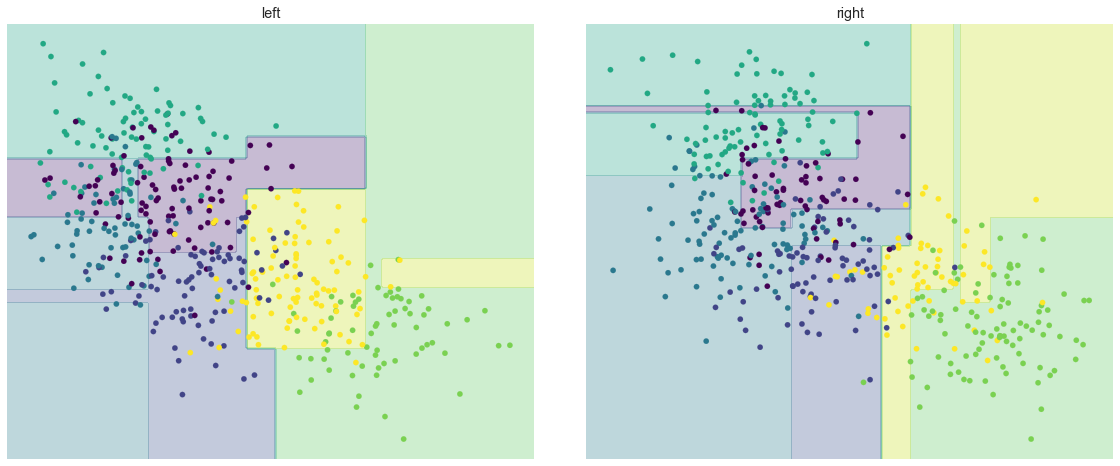

In [33]:
boundary = int(len(X) / 2)
X_left, y_left, X_right, y_right = X[:boundary], y[:boundary], X[boundary:], y[boundary:]

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
fig.subplots_adjust(left=0.02, right=0.98, wspace=0.1)

model_left = DecisionTreeClassifier(max_depth=5)
visualize_tree(model_left, X_left, y_left, ax=ax[0])
ax[0].set_title('left')

model_right = DecisionTreeClassifier(max_depth=5)
visualize_tree(model_right, X_right, y_right, ax=ax[1])
ax[1].set_title('right')
plt.show()

# Часть 1 - Ансамбли

# Часть 2 - Беггинг

Беггинг - общий подход к уменьшению дисперсии алгоритма машинного обучения. Беггинг происходит от фразы bootstrap aggregation. Bootstrap выборка - это просто выборка с повторением

Общий алгоритм:
1. Генерируем подвыборку $X_i$ размера $N$ с возвращением
2. Обучим базовый алгоритм $a_i(x)$ на выборке $X_i$
3. Повторяем шаги 1-2 $M$ раз
4. Усредняем (регрессия) или проводим голосование среди ответов $a_i(x)$

Замечания:

- Каждую подвыборку обычно делают размером с оригинальный набор данных
- Количество подвыборок должно быть достаточно, чтобы итоговая ошибка "стабилизировалась"

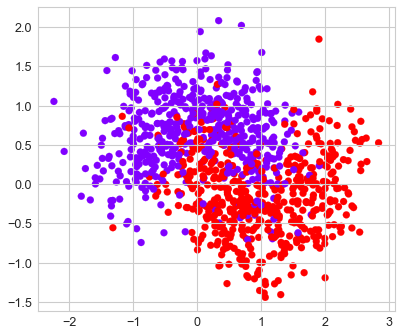

In [34]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000, shuffle=True, noise=0.4, random_state=123)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow')
plt.show()

In [36]:
# y

In [37]:
# Поделим на train и тест
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

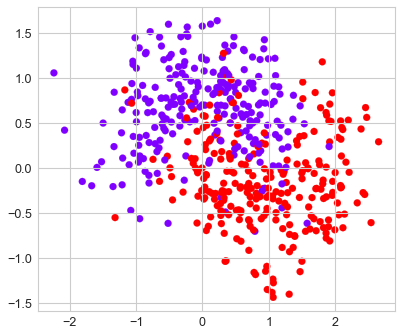

In [38]:
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=50, cmap='rainbow')
plt.show()

## Реализуем беггинг над деревьями решений для этого примера (10 деревьев)

In [39]:
estimators = 10
# create ten bootstrap samples (will be used to select rows from the DataFrame)
samples = [np.random.choice(a=X_train.shape[0], size=X_train.shape[0], replace=True) for _ in range(estimators)]

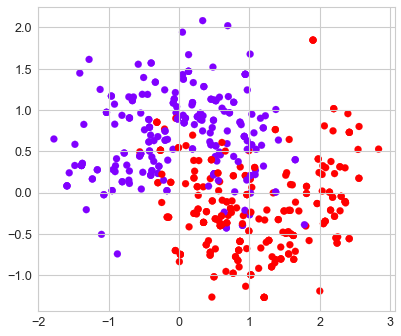

In [40]:
plt.scatter(X_train[samples[3], 0], X_train[samples[3], 1], c=y_train[samples[3]], s=50, cmap='rainbow')
plt.show()

In [41]:
models = []
for sample in samples:
    model = DecisionTreeClassifier(max_depth=None)
    model.fit(X_train[sample], y_train[sample])
    models.append(model)

In [42]:
def predict(models, X):
    predictions = None
    for m in models:
        if predictions is None:
            predictions = m.predict(X).reshape((-1, 1))
        else:
            predictions = np.hstack((predictions, m.predict(X).reshape((-1, 1))))
    result = []
    for p in predictions:
        result.append(np.bincount(p).argmax())
    return np.array(result)

In [43]:
y_pred = predict(models, X_test)
print(np.mean(y_pred == y_test))
print("MODELS")
for m in models:
    print(np.mean(m.predict(X_test) == y_test))

0.86
MODELS
0.814
0.82
0.826
0.814
0.798
0.818
0.788
0.818
0.816
0.828


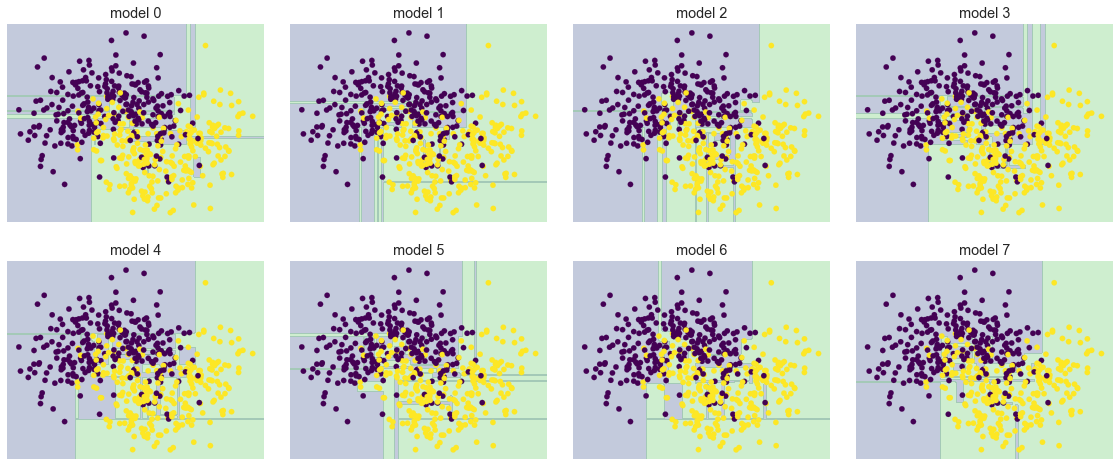

In [45]:
fig, ax = plt.subplots(2, 4, figsize=(16, 8))
fig.subplots_adjust(left=0.02, right=0.98, wspace=0.1)
for axi, index in zip(ax.flatten(), range(8)):
    visualize_tree(models[index], X_train, y_train, ax=axi, fit=False)
    axi.set_title('model {}'.format(index))

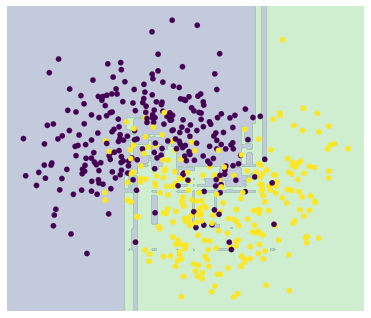

In [46]:
def visualize_bagg(models, X, y):
    ax = plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap='viridis',
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')

    xlim = ax.get_xlim()    
    ylim = ax.get_ylim()
    
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = predict(models, np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    n_classes = len(np.unique(Z))
    Z = Z.reshape(xx.shape)
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap='viridis',
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)
    
visualize_bagg(models, X_train, y_train)

### Практический пример

Используем данные страхового подразделения BNP Paribas из соревнования

https://www.kaggle.com/c/bnp-paribas-cardif-claims-management

Решается задача классификации страховых случаев:

1. Случаи, требующие дополнительных документов для подтвердения (0)    
2. Случаи, которые можно подтверждать автоматически на основе имеющейся информации (1)

In [67]:
data = pd.read_csv('train.csv')

In [68]:
# Уменьшим размер данных для ускорения обучения, возьмем случайную подвыборку 20% данных
from sklearn.model_selection import StratifiedShuffleSplit

random_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=777)

for train_index, test_index in random_splitter.split(data, data.target):
#     print(data.iloc[test_index])
    data = data.iloc[test_index]

In [69]:
data

,ID,target,v1,v2,v3,v4,v5,v6,v7,v8,...,v122,v123,v124,v125,v126,v127,v128,v129,v130,v131
79409,158563,1,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,BK,NaN,NaN,NaN,2,NaN,NaN
6038,11997,1,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,K,NaN,NaN,NaN,0,NaN,NaN
100380,200581,1,3.523809,7.334648,NaN,5.110492,5.965030,1.523809,2.095238,0.004237,...,5.000000,2.128888,0.116118,CG,1.655462,2.142857,1.295324,1,2.545454,2.857143
10485,20962,1,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,CA,NaN,NaN,NaN,1,NaN,NaN
73462,146543,0,3.908007,5.348504,C,2.281047,9.450302,2.289608,1.703577,2.734116,...,7.675438,7.843452,1.839028,AP,1.421385,0.536627,2.165703,0,3.696000,2.683982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47457,94807,1,1.474103,4.758348,C,4.516201,9.722274,2.801427,2.365277,3.851534,...,7.190083,2.608255,0.830056,D,1.143576,3.334033,2.314642,0,1.652483,1.630902
51090,102097,1,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,BJ,NaN,NaN,NaN,0,NaN,NaN
8724,17402,0,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,X,NaN,NaN,NaN,0,NaN,NaN
92031,183937,0,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,CG,NaN,NaN,NaN,0,NaN,NaN


In [70]:
# Разбиваем на train/test
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=777)

for train_index, test_index in splitter.split(data, data.target):
    d_train = data.iloc[train_index]
    d_test = data.iloc[test_index]
    
    y_train = data['target'].iloc[train_index]
    y_test = data['target'].iloc[test_index]

In [72]:
#Находим категориальные признаки
cat_feat = list(data.dtypes[data.dtypes == object].index)

#закодируем пропущенные значений строкой, факт пропущенного значения тоже может нести в себе информацию
data[cat_feat] = data[cat_feat].fillna('nan')

#отфильтруем непрерывные признаки
num_feat = [f for f in data if f not in (cat_feat + ['ID', 'target'])]

# Смотрим сколько у нас значений по каждому категориальному признаку
cat_nunique = d_train[cat_feat].nunique()
print(cat_nunique)

#Чтобы в разы не увеличивать число признаков при построении dummy,
#будем использовать категориальные признаки с < 30 уникальных значений
cat_feat = list(cat_nunique[cat_nunique < 30].index)

v3         3
v22     6610
v24        5
v30        7
v31        3
v47        9
v52       12
v56       90
v66        3
v71        5
v74        3
v75        4
v79       17
v91        7
v107       7
v110       3
v112      22
v113      34
v125      88
dtype: int64


In [73]:

# Создаем дамми-переменные для категорий
dummy_train = pd.get_dummies(d_train[cat_feat], columns=cat_feat)
dummy_test = pd.get_dummies(d_test[cat_feat], columns=cat_feat)

dummy_cols = list(set(dummy_train) & set(dummy_test))

dummy_train = dummy_train[dummy_cols]
dummy_test = dummy_test[dummy_cols]


# Заменяем пропуски на специальное значение -999, чтобы деревья могли их отличить
X_train = pd.concat([d_train[num_feat].fillna(-999),
                     dummy_train], axis=1)

X_test = pd.concat([d_test[num_feat].fillna(-999),
                     dummy_test], axis=1)

Обучаем решающее дерево

Немного ограничим глубину и минимальное кол-во объектов в листе для уменьшения переобучения

In [74]:
from sklearn.tree import DecisionTreeClassifier

clf_tree = DecisionTreeClassifier(max_depth=15, min_samples_leaf=20)
clf_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=15, min_samples_leaf=20)

In [75]:
def show_auc(y, y_pred, plot_label='', prin=True):    
    fpr, tpr, _ = roc_curve(y, y_pred)
    auc_val = auc(fpr, tpr)
    if prin:
        print('ROC AUC: {0:.4f}'.format(auc_val))
    if plot_label:
        plt.plot(fpr, tpr, label=plot_label)
        plt.xlabel('FPR')
        plt.ylabel('TPR')
    return auc_val

Train:
ROC AUC: 0.8587
Test:
ROC AUC: 0.6456


0.6456327461210648

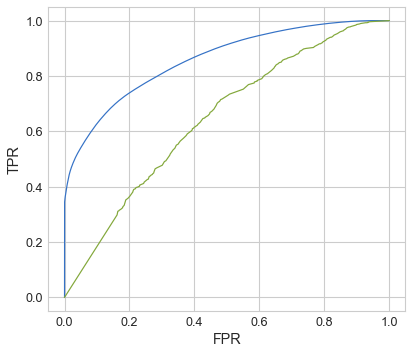

In [76]:
y_pred_test = clf_tree.predict_proba(X_test)[:, 1]
y_pred_train = clf_tree.predict_proba(X_train)[:, 1]

print('Train:')
show_auc(y_train, y_pred_train, 'train')
         
print('Test:')
show_auc(y_test, y_pred_test, 'test')

## Применим беггинг к реальным данным

Используем готовый алгоритм из sklearn

In [77]:
from sklearn.ensemble import BaggingClassifier

bag_clf = BaggingClassifier(n_estimators=20, base_estimator=clf_tree, n_jobs=-1)
bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=15,
                                                        min_samples_leaf=20),
                  n_estimators=20, n_jobs=-1)

Train:
ROC AUC: 0.8931
Test:
ROC AUC: 0.7194


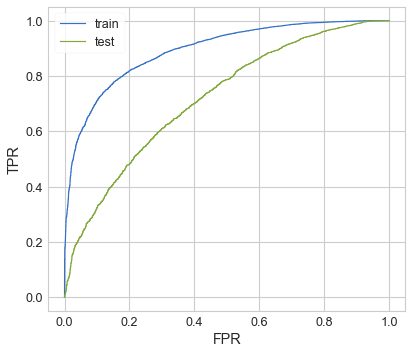

In [78]:
y_pred_test = bag_clf.predict_proba(X_test)[:, 1]
y_pred_train = bag_clf.predict_proba(X_train)[:, 1]

print('Train:')
show_auc(y_train, y_pred_train, 'train')
print('Test:')
show_auc(y_test, y_pred_test, 'test')
plt.legend();

# Часть 3. Случайный лес


**Важные гиперпараметры алгоритма**

a. Параметры деревьев
1. criterion - критерий построения дерева
2. max_depth - максимальная глубина дерева (обычно 10-20, больше глубина -> больше риск переобучения)
3. min_samples_leaf - минимальное число объектов в листе (обычно 20+, больше объектов -> меньше риск переобучения)

b. Параметры леса
1. n_estimators - кол-во деревьев (чем больше тем лучше)
2. max_features - число признаков случайного подпространства
3. n_jobs - кол-во потоков для одновременного построения деревьев (большая прибавка к скорости на многоядерных процах)

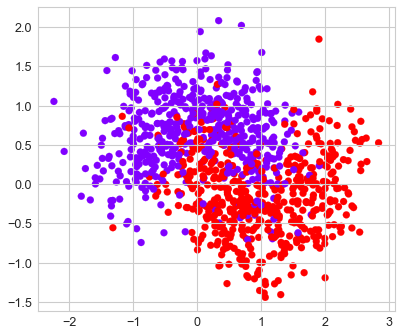

In [99]:
mX, my = make_moons(n_samples=1000, shuffle=True, noise=0.4, random_state=123)

mX_train, mX_test, my_train, my_test = train_test_split(mX, my, test_size=0.3)

plt.scatter(mX[:, 0], mX[:, 1], c=my, s=50, cmap='rainbow')
plt.show()

In [100]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(n_estimators=10, max_depth=5, min_samples_leaf=20, max_features=0.5, n_jobs=-1)
clf_rf.fit(mX_train, my_train)   

bag_clf = BaggingClassifier(n_estimators=10, base_estimator=DecisionTreeClassifier(), n_jobs=-1)
bag_clf.fit(mX_train, my_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_jobs=-1)

In [101]:
clf_rf

RandomForestClassifier(max_depth=5, max_features=0.5, min_samples_leaf=20,
                       n_estimators=10, n_jobs=-1)

Train RF:
ROC AUC: 0.9443
Test RF:
ROC AUC: 0.9399
Train BAG:
ROC AUC: 0.9991
Test BAG:
ROC AUC: 0.9098


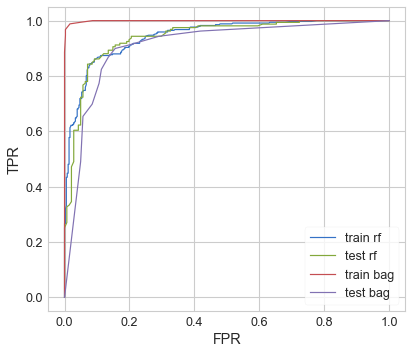

In [102]:
my_pred_test_rf = clf_rf.predict_proba(mX_test)[:, 1]
my_pred_train_rf = clf_rf.predict_proba(mX_train)[:, 1]
my_pred_test_bag = bag_clf.predict_proba(mX_test)[:, 1]
my_pred_train_bag = bag_clf.predict_proba(mX_train)[:, 1]

print('Train RF:')
show_auc(my_train, my_pred_train_rf, 'train rf')
print('Test RF:')
show_auc(my_test, my_pred_test_rf, 'test rf')
print('Train BAG:')
show_auc(my_train, my_pred_train_bag, 'train bag')
print('Test BAG:')
show_auc(my_test, my_pred_test_bag, 'test bag')

plt.legend();

## Применим случайный лес к нашему dataset'у

In [104]:
clf_rf = RandomForestClassifier(n_estimators=10, max_depth=5, min_samples_leaf=20, max_features=0.5, n_jobs=-1)
clf_rf.fit(X_train, y_train)    

RandomForestClassifier(max_depth=5, max_features=0.5, min_samples_leaf=20,
                       n_estimators=10, n_jobs=-1)

Train RF:
ROC AUC: 0.7512
Test RF:
ROC AUC: 0.7221
Train:
ROC AUC: 0.8931
Test:
ROC AUC: 0.7194


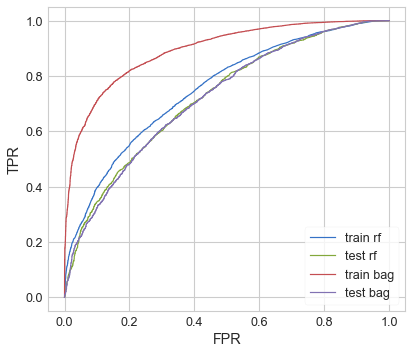

In [105]:
y_pred_test_rf = clf_rf.predict_proba(X_test)[:, 1]
y_pred_train_rf = clf_rf.predict_proba(X_train)[:, 1]


print('Train RF:')
show_auc(y_train, y_pred_train_rf, 'train rf')
print('Test RF:')
show_auc(y_test, y_pred_test_rf, 'test rf')
print('Train:')
show_auc(y_train, y_pred_train, 'train bag')
print('Test:')
show_auc(y_test, y_pred_test, 'test bag')
plt.legend();

plt.legend();

#### Важность признаков
В sklearn - усредненное по всем деревьям в ансамбле кол-во сплитов по признаку, взвешенное на прирост информации (Information gain) и долю объектов в вершине, в которой производится этот сплит

Это не единственный вариант, см здесь:

https://medium.com/@ceshine/feature-importance-measures-for-tree-models-part-i-47f187c1a2c3

Важности признаков случайного леса лежат в артибуте **feature\_importances\_**

In [106]:
imp = pd.Series(clf_rf.feature_importances_)
imp.sort_values(ascending=False)

43     0.427282
281    0.079297
343    0.079041
252    0.056983
10     0.034976
         ...   
162    0.000000
163    0.000000
164    0.000000
165    0.000000
173    0.000000
Length: 346, dtype: float64

Плюсы random_forest:
- устойчив к переобучению
- устойчивость к выбросам
- дает хорошее качество “из коробки”
- встроенная оценка важности признаков
- быстрая реализация

Минусы:
- сложность интерпретации по сравнению с одним деревом
- плохо справляется с очень большим числом признаков
- работает дольше линейных моделей

# Часть 4. Композиции моделей разных типов

Главная идея - почему ансамблирование моделей делается таким простым способом, как усреднение? Что если доверить это делому другому алгоритму машинного обучения?

### Смешаем дерево и логистическую регрессию


### Готовим признаки

In [107]:
from sklearn.preprocessing import StandardScaler

train_median = d_train[num_feat].median()

X_train = pd.concat([d_train[num_feat].fillna(train_median),
                     d_train[num_feat + cat_feat].isnull().astype(np.int8).add_suffix('_NaN'),
                     dummy_train], axis=1)

X_test = pd.concat([d_test[num_feat].fillna(train_median),
                     d_test[num_feat + cat_feat].isnull().astype(np.int8).add_suffix('_NaN'),
                     dummy_test], axis=1)

scaler = StandardScaler()
scaler.fit(X_train[num_feat])

X_train[num_feat] = scaler.transform(X_train[num_feat])
X_test[num_feat] = scaler.transform(X_test[num_feat])

## обучим стекинг

In [108]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [109]:
classifier = StackingClassifier(
    [
        ('lr', LogisticRegression()),
        ('dt', DecisionTreeClassifier())
    ],
LogisticRegression())

In [110]:
classifier.fit(X_train, y_train)

C:\Users\vanio\develop\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\vanio\develop\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

StackingClassifier(estimators=[('lr', LogisticRegression()),
                               ('dt', DecisionTreeClassifier())],
                   final_estimator=LogisticRegression())

In [111]:
classifier.named_estimators_['lr']

LogisticRegression()

In [112]:
y_pred_proba_lr = classifier.named_estimators_['lr'].predict_proba(X_test)[:,1]

In [113]:
y_pred_proba_dt = classifier.named_estimators_['dt'].predict_proba(X_test)[:,1]

In [114]:
y_pred_proba = classifier.predict_proba(X_test)[:,1]

LR
ROC AUC: 0.7219
DT
ROC AUC: 0.5788
STACK
ROC AUC: 0.7233


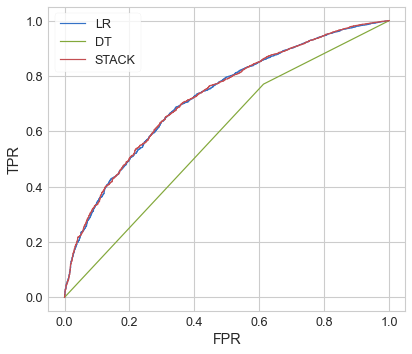

In [115]:
print("LR")
show_auc(y_test, y_pred_proba_lr, 'LR')
print("DT")
show_auc(y_test, y_pred_proba_dt, 'DT')
print("STACK")
show_auc(y_test, y_pred_proba, 'STACK')
plt.legend()
plt.show()

#### Посмотрим на коэффициенты объединяющей линейной модели

In [116]:
classifier.final_estimator_

LogisticRegression()

<AxesSubplot:>

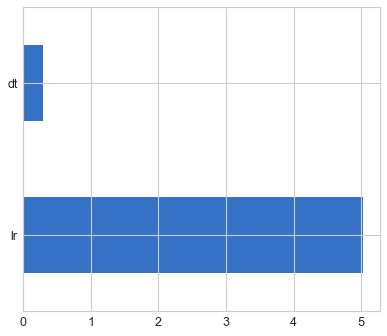

In [117]:
pd.Series(classifier.final_estimator_.coef_.flatten(), index=classifier.named_estimators_.keys()).plot(kind='barh')

# Домашняя работа

1. Теперь решаем задачу регрессии - предскажем цены на недвижимость. Использовать датасет https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data (train.csv)
2. Построить случайный лес, вывести важность признаков
3. Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную
4. В качестве решения: Jupyter notebook с кодом, комментариями и графиками